# Multi Asset Scheduling Testbench

## Setup

In [2]:
from flexmeasures.app import create
from flexmeasures.data.models.time_series import Sensor

from datetime import timedelta

from flexmeasures.data.utils import save_to_db

from sqlalchemy import select, update
import time

import timely_beliefs as tb
import pandas as pd
import numpy as np

from flexmeasures.data.services.utils import get_or_create_model
from flexmeasures import Asset, Sensor, AssetType, Account, Source
from flexmeasures.data.models.time_series import TimedBelief

app = create()
ctx = app.app_context()
ctx.__enter__()
session = app.db.session

You might consider setting MAIL_PASSWORD.
[FLEXMEASURES][2025-03-11 11:42:38,415] WARNING: Support for Torch based models not available. To enable them, install "darts", "u8darts[torch]" or "u8darts[all]" (with pip); or "u8darts-torch" or "u8darts-all" (with conda).


In [3]:
session.rollback()

### Create Asset and Asset Types

In [4]:
## Create asset types
site_type = AssetType(name="site")
building_type = AssetType(name="building")
ev_type = AssetType(name="ev")
solar_type = AssetType(name="solar panel")
battery_type = AssetType(name="battery")

asset_types = [site_type, building_type, ev_type, solar_type, battery_type]

session.add_all(asset_types)
session.flush()

## Create Assets
coordinates = {"latitude": 0, "longitude": 0}
test_site = Asset(name="Test Site", generic_asset_type_id=site_type.id, **coordinates)
session.add(test_site)
session.flush()

test_building = Asset(
    name="Test Building",
    generic_asset_type_id=building_type.id,
    parent_asset_id=test_site.id,
    **coordinates,
)
test_solar = Asset(
    name="Test Solar",
    generic_asset_type_id=solar_type.id,
    parent_asset_id=test_site.id,
    **coordinates,
)
test_battery = Asset(
    name="Test Battery",
    generic_asset_type_id=battery_type.id,
    parent_asset_id=test_site.id,
    **coordinates,
)
test_ev = Asset(
    name="Test EV",
    generic_asset_type_id=ev_type.id,
    parent_asset_id=test_site.id,
    **coordinates,
)
test_battery_1h = Asset(
    name="Test Battery 1h",
    generic_asset_type_id=battery_type.id,
    parent_asset_id=test_site.id,
    **coordinates,
)

assets = (
    test_site,
    test_building,
    test_solar,
    test_battery,
    test_ev,
    test_battery_1h,
)

session.add_all(assets)
session.flush()

sensors = dict()

# Add power sensor
for asset in assets:
    sensor = Sensor(
        name="power",
        unit="MW",
        event_resolution=(
            timedelta(hours=1)
            if asset.name == "Test Battery 1h"
            else timedelta(minutes=15)
        ),
        generic_asset=asset,
        timezone="Europe/Amsterdam",
    )
    sensors[asset.name] = sensor

session.add_all(list(sensors.values()))
session.flush()

In [5]:
Asset.query.all()

[<GenericAsset 8: 'Test Site' (site)>,
 <GenericAsset 9: 'Test Building' (building)>,
 <GenericAsset 10: 'Test Solar' (solar panel)>,
 <GenericAsset 11: 'Test Battery' (battery)>,
 <GenericAsset 12: 'Test EV' (ev)>,
 <GenericAsset 13: 'Test Battery 1h' (battery)>]

In [6]:
Sensor.query.all()

[<Sensor 8: power, unit: MW res.: 0:15:00>,
 <Sensor 9: power, unit: MW res.: 0:15:00>,
 <Sensor 10: power, unit: MW res.: 0:15:00>,
 <Sensor 11: power, unit: MW res.: 0:15:00>,
 <Sensor 12: power, unit: MW res.: 0:15:00>,
 <Sensor 13: power, unit: MW res.: 1:00:00>]

### Create Market Asset and Price sensor

In [7]:
from timely_beliefs.sensors.func_store.knowledge_horizons import x_days_ago_at_y_oclock

# Create the epex_da market
day_ahead = AssetType(
    name="day_ahead",
)
epex = Asset(
    name="epex",
    generic_asset_type=day_ahead,
)

price_sensors = {}
for sensor_name in ["epex_da"]:
    price_sensor = Sensor(
        name=sensor_name,
        generic_asset=epex,
        event_resolution=timedelta(hours=1),
        unit="EUR/MWh",
        knowledge_horizon=(
            x_days_ago_at_y_oclock,
            {"x": 1, "y": 12, "z": "Europe/Paris"},
        ),
        attributes=dict(
            daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=True,
        ),
    )
    session.add(price_sensor)
    price_sensors[sensor_name] = price_sensor
session.flush()


In [8]:
seita_source = Source(name="Seita", type="demo script")
session.add(seita_source)
session.flush()

In [9]:
Asset.query.all()

[<GenericAsset 8: 'Test Site' (site)>,
 <GenericAsset 9: 'Test Building' (building)>,
 <GenericAsset 10: 'Test Solar' (solar panel)>,
 <GenericAsset 11: 'Test Battery' (battery)>,
 <GenericAsset 12: 'Test EV' (ev)>,
 <GenericAsset 13: 'Test Battery 1h' (battery)>,
 <GenericAsset 14: 'epex' (day_ahead)>]

In [10]:
from isodate import parse_duration
def add_beliefs(
    session,
    sensor: Sensor,
    time_slots: pd.DatetimeIndex,
    values: list[int | float] | np.ndarray,
    source: Source,
):
    beliefs = [
        TimedBelief(
            event_start=dt,
            belief_time=pd.Timestamp.now(tz="Europe/Amsterdam"),
            event_value=val,
            sensor=sensor,
            source=source,
        )
        for dt, val in zip(time_slots, values)
    ]
    session.add_all(beliefs)

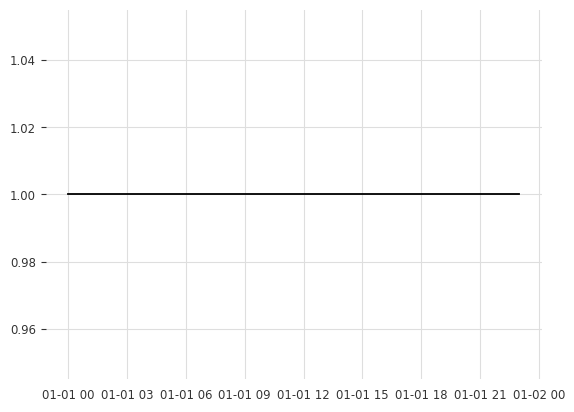

In [97]:
import matplotlib.pyplot as plt
from flexmeasures.data.models.planning.utils import initialize_index
from random import random, seed
import numpy as np

start = pd.Timestamp("2015-01-01").tz_localize("Europe/Amsterdam")
end = pd.Timestamp("2015-01-02").tz_localize("Europe/Amsterdam")

time_slots = initialize_index(
    start=start,
    end=end,
    resolution="1H",
)
values = [1 for x in range(len(time_slots))]
#values = [random() * (1 + np.sin(x * 2 * np.pi / 24)) for x in range(len(time_slots))]

# values[4] = 40
# values[8] = 100

add_beliefs(
    session=session,
    sensor=price_sensor,
    time_slots=time_slots,
    values=values,
    source=seita_source,
)

session.flush()

plt.plot(time_slots, values)
plt.show()

### Add data to Solar

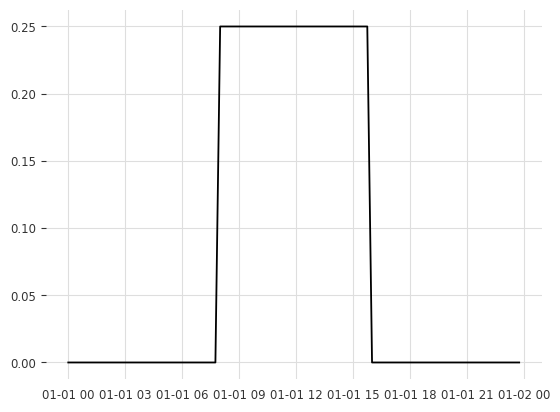

In [98]:
time_slots = initialize_index(
    start=start,
    end=end,
    resolution="15min",
)
values = np.array([0.0 for x in range(len(time_slots))])
#values = [random() * (1 + np.sin(x * 2 * np.pi / 24)) for x in range(len(time_slots))]

values[8*4:16*4] = .25 #0.25 #-0.25

add_beliefs(
    session=session,
    sensor=sensors["Test Solar"],
    time_slots=time_slots,
    values=values.tolist(),
    source=seita_source,
)

session.flush()
data = sensors["Test Solar"].search_beliefs()
data = data.reset_index(["belief_time", "cumulative_probability", "source"])[["event_value"]]
plt.plot(data)
plt.show()

## Call scheduler

In [127]:
# flex_model = [
#     {
#         "sensor": sensors["Test Battery"].id,
#         "consumption-capacity": "100kW",
#         "production-capacity": "100kW",
#         "power-capacity": "100kW",
#         "soc-at-start": 0.01,  # 100 kWh
#         "soc-unit": "MWh",
#         "soc-min": 0.0,
#         "soc-max": 0.1,  # 100 kWh
#     },
# ]
flex_model = [
    {
        "sensor": sensors["Test Battery"].id,
        "consumption-capacity": "100kW",
        "production-capacity": "100kW",
        "power-capacity": "100kW",
        "soc-at-start": 0.0,  # 100 kWh
        "soc-unit": "MWh",
        "soc-min": 0.0,
        "soc-max": 0.1,  # 100 kWh
    },
    {
        "sensor": sensors["Test Solar"].id,
        "consumption-capacity": "0kW",
        "production-capacity": {"sensor": sensors["Test Solar"].id},
        "power-capacity": "1000kW",
        "soc-at-start": 10000,  # 100 kWh
        "soc-unit": "MWh",
        "soc-min": -100000,
        "soc-max": 100000,  # 100 kWh
    },
    # {
    #     "sensor": sensors["Test Solar"].id,
    #     "consumption-capacity": "0kW",
    #     "production-capacity": {"sensor": sensors["Test Solar"].id},
    #     "power-capacity": "1000kW",
    #     "soc-at-start": 0,  # 100 kWh
    #     "soc-unit": "MWh",
    #     "soc-min": -10000,
    #     "soc-max": 10000,  # 100 kWh
    # },
]
flex_context = {
    "consumption-price": {"sensor" : price_sensor.id},
    "production-price":  {"sensor" : price_sensor.id},
    "site-production-capacity": "100kW",
    "site-consumption-capacity": "100kW",
    "site-consumption-breach-price" : "100 EUR/MW",
    "site-production-breach-price" : "100 EUR/MW"
}

# flex_context = {
#     "consumption-price-sensor": price_sensor.id,
#     "production-price-sensor": price_sensor.id,
#     "inflexible-device-sensors": [
#         sensors["Test Solar"].id,
#     ],
#     "site-production-capacity": "100kW",
#     "site-consumption-capacity": "100kW",
# }

In [128]:
from flexmeasures.data.models.planning.storage import StorageScheduler

scheduler = StorageScheduler(
    asset_or_sensor=test_site,
    start=start,
    end=end,
    resolution="PT15M",
    flex_model=flex_model,
    flex_context=flex_context,
    return_multiple=True
)
result = scheduler.compute()

In [129]:
result

[{'name': 'storage_schedule',
  'sensor': <Sensor 11: power, unit: MW res.: 0:15:00>,
  'data': datetime
  2014-12-31 23:00:00+00:00    0.1
  2014-12-31 23:15:00+00:00    0.1
  2014-12-31 23:30:00+00:00    0.1
  2014-12-31 23:45:00+00:00    0.1
  2015-01-01 00:00:00+00:00    0.0
                              ... 
  2015-01-01 21:45:00+00:00    0.0
  2015-01-01 22:00:00+00:00   -0.1
  2015-01-01 22:15:00+00:00   -0.1
  2015-01-01 22:30:00+00:00   -0.1
  2015-01-01 22:45:00+00:00   -0.1
  Freq: 15min, Length: 96, dtype: float64},
 {'name': 'storage_schedule',
  'sensor': <Sensor 10: power, unit: MW res.: 0:15:00>,
  'data': datetime
  2014-12-31 23:00:00+00:00   -0.0
  2014-12-31 23:15:00+00:00   -0.0
  2014-12-31 23:30:00+00:00   -0.0
  2014-12-31 23:45:00+00:00   -0.0
  2015-01-01 00:00:00+00:00   -0.0
                              ... 
  2015-01-01 21:45:00+00:00   -0.0
  2015-01-01 22:00:00+00:00   -0.0
  2015-01-01 22:15:00+00:00   -0.0
  2015-01-01 22:30:00+00:00   -0.0
  2015-01-0

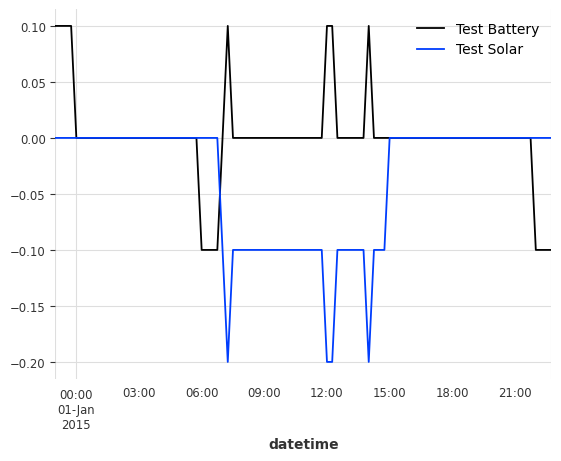

In [130]:
result[0]["data"].plot()
result[1]["data"].plot()
plt.legend([result[0]["sensor"].generic_asset.name, result[1]["sensor"].generic_asset.name])
plt.show()

In [26]:
flex_model = [
    {
        "sensor": sensors["Test Battery"].id,
        "consumption-capacity": "100kW",
        "production-capacity": "100kW",
        "power-capacity": "100kW",
        "soc-at-start": 0.01,  # 100 kWh
        "soc-unit": "MWh",
        "soc-min": 0.0,
        "soc-max": 0.1,  # 100 kWh
    },
]